<a href="https://colab.research.google.com/github/michalis0/DataScience_and_MachineLearning/blob/master/Assignements/Part%203/Assignment_part_three.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DSML investigation:

You are part of the Suisse Impossible Mission Force, or SIMF for short. You need to uncover a rogue agent that is trying to steal sensitive information.

Your mission, should you choose to accept it, is to find that agent before stealing any classified information. Good luck!

# Assignement part three
### Due 15.10.2023

We received new intelligence informing us that the rogue agent has a position with great responsibility.
Use the table "HR_Analytics.csv" to create a classifier model that predicts the job role of a person. Use this model to predict the roles of the table of suspects "suspect_HR_data.csv".

Retain only the list of suspects whose role indicates high responsibility.


## Getting to know our data

- BusinessTravel: The frequency of business travel for the employee. (Categorical)
- DailyRate: The daily rate of pay for the employee. (Numerical)
- DistanceFromHome: The distance from home in miles for the employee. (Numerical)
- Education: The level of education achieved by the employee. (Categorical)
- EmployeeCount: The total number of employees in the organization. (Numerical)
- EmployeeNumber: A unique identifier for each employee profile. (Numerical)
- EnvironmentSatisfaction: The employee's satisfaction with their work environment. (Categorical)
- Gender: The gender of the employee. (Categorical)
- HourlyRate: The hourly rate of pay for the employee. (Numerical)
- JobInvolvement: The level of involvement required for the employee's job. (Categorical)
- JobLevel: The job level of the employee. (Categorical)
- JobSatisfaction: The employee's satisfaction with their job. (Categorical)
- MonthlyIncome: The monthly income of the employee. (Numerical)
- MonthlyRate: The monthly rate of pay for the employee. (Numerical)
- NumCompaniesWorked: The number of companies the employee has worked for. (Numerical)
- Over18: Whether or not the employee is over 18. (Categorical)
- OverTime: Whether or not the employee works overtime. (Categorical)
- PercentSalaryHike: The percentage of salary hike for the employee. (Numerical)
- PerformanceRating: The performance rating of the employee. (Categorical)
- RelationshipSatisfaction: The employee's satisfaction with their relationships. (Categorical)
- StandardHours: The standard hours of work for the employee. (Numerical)
- StockOptionLevel: The stock option level of the employee. (Numerical)
- TotalWorkingYears: The total number of years the employee has worked. (Numerical)
- TrainingTimesLastYear: The number of times the employee was taken for training in the last year. (Numerical)
- WorkLifeBalance: The employee's perception of their work-life balance. (Categorical)
- YearsAtCompany: The number of years the employee has been with the company. (Numerical)
- YearsInCurrentRole: The number of years the employee has been in their current role. (Numerical)
- YearsSinceLastPromotion: The number of years since the employee's last promotion. (Numerical)
- YearsWithCurrManager: The number of years the employee has been with their current manager. (Numerical)

In [1]:
# Import required packages
# Import required packages
import  numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder , MinMaxScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.pipeline import Pipeline
%matplotlib inline

df = pd.read_csv("https://raw.githubusercontent.com/michalis0/DataScience_and_MachineLearning/master/Assignements/Part%203/data/HR_Analytics.csv", index_col='Unnamed: 0')
suspects = pd.read_csv("https://raw.githubusercontent.com/michalis0/DataScience_and_MachineLearning/master/Assignements/Part%203/data/suspects.csv", index_col='Unnamed: 0')


### Let's check the data


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1470 entries, 0 to 1469
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   BusinessTravel            1470 non-null   object
 1   DailyRate                 1470 non-null   int64 
 2   DistanceFromHome          1470 non-null   int64 
 3   Education                 1470 non-null   int64 
 4   EmployeeCount             1470 non-null   int64 
 5   EmployeeNumber            1470 non-null   int64 
 6   EnvironmentSatisfaction   1470 non-null   int64 
 7   Gender                    1470 non-null   object
 8   HourlyRate                1470 non-null   int64 
 9   JobInvolvement            1470 non-null   int64 
 10  JobLevel                  1470 non-null   int64 
 11  JobSatisfaction           1470 non-null   int64 
 12  MonthlyIncome             1470 non-null   int64 
 13  MonthlyRate               1470 non-null   int64 
 14  NumCompaniesWorked        147

## 1. Define a pipeline that encodes features as follows:

* Use one-hot encoding for `BusinessTravel`
* Use label encoding for `Gender` and `OverTime`


In [3]:
def Pipeline(train: pd.DataFrame, test: pd.DataFrame):
    # 1. One-hot encoding for BusinessTravel
    train = pd.get_dummies(train, columns=['BusinessTravel'], prefix=['BusinessTravel'])
    test = pd.get_dummies(test, columns=['BusinessTravel'], prefix=['BusinessTravel'])
    #encoder = OneHotEncoder(drop='first', sparse = False)
    #encoder.fit(train[['BusinessTravel']])
    #train = encoder.transform(train[['BusinessTravel']])
    #test = encoder.transform(test[['BusinessTravel']])
    # 2. Label encoding for Gender and OverTime
    label_encoders = {}
    label_cols = ['Gender', 'OverTime']
    for col in label_cols:
        le = LabelEncoder()
        train[col] = le.fit_transform(train[col])
        test[col] = le.transform(test[col])
        label_encoders[col] = le

    boolean_columns = ['BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely']

    for column in boolean_columns:
        train[column] = train[column].astype(int)
        test[column] = test[column].astype(int)

    # 3. Concatenate the datasets
    #df_train = train.copy()
    #df_test = test.copy()
    combined_df = pd.concat([train, test], axis=0)

    # 4. Apply Min-Max scaling fitted on the train dataset
    numeric_cols = ['DailyRate', 'DistanceFromHome', 'HourlyRate', 'MonthlyIncome', 'MonthlyRate',
                    'NumCompaniesWorked', 'PercentSalaryHike', 'StandardHours', 'StockOptionLevel',
                    'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany',
                    'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

    #scaler = MinMaxScaler()
    #df_train[numeric_cols] = scaler.fit_transform(df_train[numeric_cols])
    #df_test[numeric_cols] = scaler.transform(df_test[numeric_cols])
    scaler = MinMaxScaler()
    combined_df[numeric_cols] = scaler.fit_transform(combined_df[numeric_cols])

    # Split the concatenated dataset back into train and test sets
    train_size = len(train)
    df_train = combined_df[:train_size]
    df_test = combined_df[train_size:]

    return df_train, df_test


### 1.1 Define your dependent variable y ("JobLevel") and your independent features X

In [4]:
# Your code here
df_train_processed, df_test_processed = Pipeline(df, suspects)
df_train_processed = df_train_processed.dropna(axis=1)
df_test_processed = df_test_processed.dropna(axis=1)
print(df_train_processed, df_test_processed)

      DailyRate  DistanceFromHome  Education  EmployeeCount  EmployeeNumber  \
0      0.715820          0.000000          2              1               1   
1      0.126700          0.250000          1              1               2   
2      0.909807          0.035714          2              1               4   
3      0.923407          0.071429          4              1               5   
4      0.350036          0.035714          1              1               7   
...         ...               ...        ...            ...             ...   
1465   0.559771          0.785714          2              1            2061   
1466   0.365784          0.178571          1              1            2062   
1467   0.037938          0.107143          3              1            2064   
1468   0.659270          0.035714          3              1            2065   
1469   0.376521          0.250000          3              1            2068   

      EnvironmentSatisfaction  Gender  HourlyRate  

## 2. Logistic Regression

In this section we will use logistic regression to predict the JobLevel of the potential suspects.

To do so you can reuse the pipeline created in part 1.

#### 2.1 Use logistic regression to predict the `JobLevel` based on all variables over the test set. 
You can use a test_size of 0.2 and random a random state of 42
(use logistic regression with the lbfgs solver, 5 fold cross validation and max_iter = 100)

Use only the HR analytics dataset to collect accurate insight on the model

In [5]:
# Your code here
# Split the data into features (X) and target (y)
y_train = df_train_processed['JobLevel']
X_train = df_train_processed.drop(columns=['JobLevel'])

# Split the data into training and testing sets with a test size of 0.2 and a random state of 42
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)


# Initialize and train a logistic regression model
logistic_regression_model = LogisticRegression(solver='lbfgs', max_iter=100)
logistic_regression_model.fit(X_train, y_train)

/home/nathan/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [6]:
y_test_pred = logistic_regression_model.predict(X_test)
y_train_pred = logistic_regression_model.predict(X_train)
print(y_test_pred, y_train_pred)

[1. 1. 1. 1. 1. 1. 2. 2. 2. 1. 2. 2. 1. 2. 1. 2. 1. 2. 4. 3. 2. 1. 2. 1.
 1. 2. 1. 1. 1. 2. 1. 1. 1. 1. 2. 2. 2. 1. 1. 1. 2. 1. 2. 2. 1. 2. 2. 1.
 2. 1. 1. 1. 3. 1. 2. 1. 1. 1. 1. 1. 2. 1. 2. 1. 1. 2. 2. 1. 1. 1. 1. 4.
 1. 2. 1. 2. 2. 1. 2. 1. 2. 1. 2. 1. 2. 1. 1. 2. 1. 1. 2. 1. 2. 1. 2. 2.
 2. 2. 1. 2. 4. 2. 2. 1. 2. 2. 2. 2. 2. 2. 1. 2. 1. 1. 1. 2. 1. 4. 2. 1.
 1. 1. 1. 2. 3. 1. 2. 2. 2. 2. 2. 1. 3. 2. 1. 2. 2. 2. 1. 2. 1. 1. 2. 1.
 2. 2. 2. 1. 1. 1. 2. 2. 1. 1. 2. 1. 1. 1. 2. 1. 2. 2. 2. 1. 2. 2. 2. 2.
 2. 2. 2. 3. 2. 1. 2. 1. 2. 1. 1. 1. 2. 1. 4. 1. 1. 1. 1. 2. 1. 1. 1. 4.
 2. 1. 1. 1. 1. 2. 2. 2. 2. 1. 1. 2. 1. 1. 4. 2. 2. 4. 2. 1. 1. 1. 2. 2.
 2. 1. 1. 2. 2. 1. 2. 2. 2. 1. 2. 2. 2. 1. 1. 1. 1. 2. 2. 1. 2. 1. 2. 2.
 1. 2. 1. 1. 2. 1. 2. 1. 2. 1. 1. 2. 3. 1. 1. 1. 1. 1. 1. 2. 2. 2. 1. 2.
 2. 1. 2. 2. 1. 1. 2. 1. 1. 1. 2. 2. 1. 1. 2. 2. 2. 2. 1. 1. 1. 2. 1. 1.
 1. 1. 2. 2. 1. 2.] [1. 1. 1. ... 2. 2. 2.]


In [7]:
model_cv = LogisticRegressionCV(penalty='l2', solver='lbfgs', cv=5, max_iter=100)

# Fit our model
model_cv.fit(X_train, y_train)

/home/nathan/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


/home/nathan/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/nathan/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

LogisticRegressionCV(cv=5)

#### 2.1.2 Display the confusion matrix and the other accuracy measures seen in class.


0.3979591836734694
0.48299319727891155


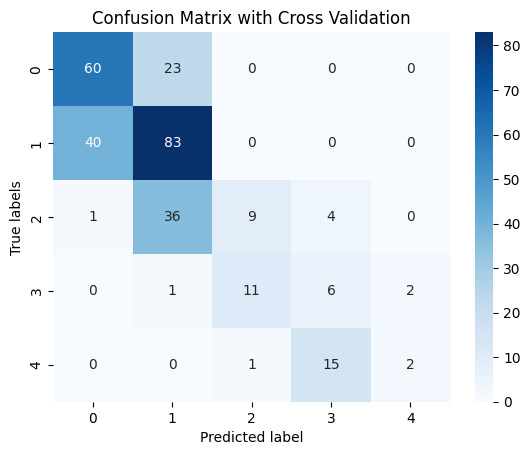

In [8]:
# Your code here
confusion_cv = confusion_matrix(y_test, model_cv.predict(X_test))
# Heatmap of confusion matrix
sns.heatmap(confusion_cv, annot=True, cmap='Blues', fmt='.4g')
plt.xlabel('Predicted label')
plt.ylabel('True labels')
plt.title('Confusion Matrix with Cross Validation');
#print(confusion_matrix(y_test, y_test))
#print(confusion_matrix(y_train, y_train_pred))
print(logistic_regression_model.score(X_test, y_test))
print(logistic_regression_model.score(X_train, y_train))
#model_proba = pd.DataFrame(logistic_regression_model.predict_proba(X_test),
                           #columns=['Probability level 1', 'Probability level 2','Probability level 3', 'Probability level 4', 'Probability level 5'])

In [9]:
# Accuracy on the test set
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logistic_regression_model.score(X_test, y_test)))

# Accuracy on the training set
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logistic_regression_model.score(X_train, y_train)))

Accuracy of Logistic regression classifier on test set: 0.40
Accuracy of Logistic regression classifier on training set: 0.48


In [10]:
# Accuracy on the test set
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logistic_regression_model.score(X_test, y_test)))
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='macro')
recall = recall_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy of Logistic regression classifier on test set: 0.40
Accuracy: 0.40
Precision: 0.20
Recall: 0.24
F1 Score: 0.20


/home/nathan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### 2.2 Predicting suspects Job Level
Retrain a logistic regression model on the **full train dataset** and predict the JobLevel of the suspects. (do not forget to apply the pipeline)

Training on part of the dataset is mainly usefull so that we get an idea of the results we should expect but also performing various optimisations.

In order to get the best result possible it is advised to retrain on the entire set prior to making predictions.

(use logistic regression with the lbfgs solver, 5 fold cross validation and max_iter = 100)

In [11]:
# Your code here
preprocessed_train, preprocessed_test = Pipeline(df, suspects)
preprocessed_train = preprocessed_train.dropna(axis=1)
preprocessed_test = preprocessed_test.dropna(axis=1)
print(preprocessed_train.head(),preprocessed_test.head())

   DailyRate  DistanceFromHome  Education  EmployeeCount  EmployeeNumber  \
0   0.715820          0.000000          2              1               1   
1   0.126700          0.250000          1              1               2   
2   0.909807          0.035714          2              1               4   
3   0.923407          0.071429          4              1               5   
4   0.350036          0.035714          1              1               7   

   EnvironmentSatisfaction  Gender  HourlyRate  JobInvolvement  JobLevel  ...  \
0                        2       0    0.914286               3       2.0  ...   
1                        3       1    0.442857               2       2.0  ...   
2                        4       1    0.885714               2       1.0  ...   
3                        4       0    0.371429               3       1.0  ...   
4                        1       1    0.142857               3       1.0  ...   

   TotalWorkingYears  TrainingTimesLastYear  WorkLifeBal

In [12]:
preprocessed_test = preprocessed_test.drop(columns=['userID'])
X = preprocessed_train.drop(columns=['JobLevel'])
y = preprocessed_train['JobLevel']


In [13]:
model_full = LogisticRegression(solver='lbfgs', max_iter=1000)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
precision_scorer = make_scorer(precision_score, average = 'macro')
precision_scores = cross_val_score(model_full, X, y, cv=kf, scoring=precision_scorer)
print("Precision Scores for Each Fold:", precision_scores)
print("Mean Precision:", precision_scores.mean())

# Retrain the model on the entire train dataset
model_full.fit(X, y)

# Make predictions on the test dataset
y_pred = model_full.predict(preprocessed_test)
print(y_pred)

/home/nathan/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/nathan/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

Precision Scores for Each Fold: [0.46262208 0.38604832 0.48628685 0.6170024  0.38515671]
Mean Precision: 0.4674232708924582
[2. 2. 1. 1. 1. 1. 1. 1. 2. 2. 1. 2. 1. 1. 1. 3. 1. 1. 3. 1. 1. 1. 3. 1.
 1. 3. 1. 2. 3. 4. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 4. 2. 1.
 2. 1. 2. 1. 1. 2. 2. 3. 2. 1. 2. 2. 2. 2. 4. 3. 3. 3. 1. 2. 1. 1. 2. 1.
 1. 2. 1. 2. 2. 2. 3. 1. 2. 1. 2. 2. 1. 2. 1. 1. 2. 2. 3. 3. 2. 3. 2. 3.
 1. 1. 4. 2. 1. 1. 1. 2. 2. 3. 4. 2. 1. 1. 3. 2. 4. 1. 1. 2. 3. 2. 1. 3.
 2. 2. 2. 3. 2. 1. 4. 1. 1. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 1. 1.
 2. 1. 1. 3. 1. 1. 2. 2. 1. 2. 2. 2. 1. 1. 3. 1. 1. 1. 1. 2. 1. 3. 2. 3.
 2. 1. 1. 1. 2. 2. 2. 2. 1. 1. 3. 1. 1. 1. 1. 1. 1. 2. 3. 4. 2. 3. 5. 1.
 1. 1. 3. 2. 1. 2. 1. 2. 1. 2. 1. 2. 2. 2. 1. 1. 2. 2. 3. 2. 2. 3. 1. 2.
 2. 1. 3. 2. 2. 1. 2. 3. 1. 1. 2. 3. 2. 1. 1. 3. 1. 4. 2. 3. 2. 4. 1. 1.
 1. 1. 1. 2. 5. 2. 1. 2. 1. 1. 2. 3. 1. 2. 1. 1. 2. 3. 1. 1. 1. 2. 1. 4.
 1. 1. 2. 2. 3. 2. 5. 3. 1. 2. 1. 2. 3. 2. 1. 3. 3. 2. 2. 2. 1. 2. 1. 2.


/home/nathan/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## 3. Decision tree

In this section we will use the decision tree model to predict the JobLevel of the potential suspects.

To do so you can reuse the pipeline created in part 1.

#### 3.1 Use Decision Tree classifier to predict the JobLevel based on all variables. Display the confusion matrix and the other accuracy measures seen in class.
You can use a test_size of 0.2 and random a random state of 42

The max depth for the decision tree can be 5


Use only the HR analytics dataset to collect accurate insight on the model

In [14]:
# Your code here
y_train = df_train_processed['JobLevel']
X_train = df_train_processed.drop(columns=['JobLevel'])

# Split the data into training and testing sets with a test size of 0.2 and a random state of 42
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

In [15]:
clf = DecisionTreeClassifier(max_depth=5)

clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
print(clf.score(X_train, y_train))


0.9149659863945578
0.9328231292517006


In [16]:
y_dct_pred = clf.predict(X_test)
print(y_dct_pred)

[2. 2. 1. 3. 2. 1. 1. 1. 3. 1. 1. 3. 2. 1. 1. 2. 2. 1. 3. 4. 1. 2. 2. 2.
 2. 5. 1. 2. 1. 2. 2. 2. 2. 3. 2. 3. 4. 1. 1. 1. 3. 2. 2. 1. 1. 2. 3. 2.
 2. 1. 4. 2. 5. 2. 1. 2. 1. 2. 2. 2. 3. 1. 3. 4. 2. 2. 2. 2. 1. 4. 2. 5.
 3. 2. 2. 4. 2. 2. 3. 3. 5. 2. 4. 1. 3. 1. 3. 2. 2. 2. 2. 1. 3. 1. 3. 3.
 3. 2. 2. 3. 5. 3. 3. 1. 3. 3. 2. 2. 3. 5. 2. 2. 2. 2. 1. 1. 2. 3. 4. 1.
 1. 3. 1. 3. 2. 1. 2. 3. 2. 2. 1. 1. 3. 2. 2. 2. 1. 3. 1. 4. 1. 3. 2. 3.
 4. 1. 2. 1. 1. 2. 2. 3. 2. 1. 2. 2. 2. 1. 5. 1. 2. 2. 2. 1. 1. 2. 1. 1.
 4. 3. 2. 4. 1. 1. 2. 1. 2. 3. 3. 1. 3. 2. 5. 3. 3. 1. 3. 3. 3. 2. 2. 3.
 3. 2. 2. 1. 1. 5. 2. 2. 1. 2. 2. 5. 4. 1. 3. 1. 1. 5. 3. 1. 1. 3. 3. 1.
 2. 2. 2. 3. 1. 1. 3. 2. 2. 1. 2. 2. 3. 1. 2. 2. 5. 3. 2. 1. 2. 1. 4. 5.
 1. 2. 2. 5. 3. 2. 1. 2. 2. 2. 2. 5. 5. 2. 2. 2. 1. 1. 1. 4. 2. 1. 1. 2.
 2. 3. 5. 3. 2. 2. 1. 5. 2. 2. 3. 2. 1. 2. 2. 3. 2. 2. 1. 3. 4. 1. 2. 1.
 2. 2. 2. 4. 2. 1.]


#### 3.1.2 Display the confusion matrix and the other accuracy measures seen in class.


In [17]:
# Your code here
confusion_mat = confusion_matrix(y_test, y_dct_pred)
print("Confusion Matrix:")
print(confusion_mat)

Confusion Matrix:
[[ 75   8   0   0   0]
 [  6 111   6   0   0]
 [  0   0  49   1   0]
 [  0   0   4  16   0]
 [  0   0   0   0  18]]


In [18]:
accuracy = accuracy_score(y_test, y_dct_pred)
precision = precision_score(y_test, y_dct_pred, average='weighted')
recall = recall_score(y_test, y_dct_pred, average='weighted')
f1 = f1_score(y_test, y_dct_pred, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 0.91
Precision: 0.92
Recall: 0.91
F1 Score: 0.91


#### 3.2 Predicting suspects Job Level according to the decision tree
Retrain a decision tree model on the full train dataset and predict the JobLevel of the suspects. 

Training on part of the dataset is mainly usefull so that we get an idea of the results we should expect but also performing various optimisations.

In order to get the best result possible it is advised to retrain on the entire set prior to making predictions.

The max depth for the decision tree can be 5

In [19]:
# Your code here
preprocessed_train, preprocessed_test = Pipeline(df, suspects)
preprocessed_train = preprocessed_train.dropna(axis=1)
preprocessed_test = preprocessed_test.dropna(axis=1)
print(preprocessed_train.head(),preprocessed_test.head())
preprocessed_test = preprocessed_test.drop(columns=['userID'])
X = preprocessed_train.drop(columns=['JobLevel'])
y = preprocessed_train['JobLevel']

   DailyRate  DistanceFromHome  Education  EmployeeCount  EmployeeNumber  \
0   0.715820          0.000000          2              1               1   
1   0.126700          0.250000          1              1               2   
2   0.909807          0.035714          2              1               4   
3   0.923407          0.071429          4              1               5   
4   0.350036          0.035714          1              1               7   

   EnvironmentSatisfaction  Gender  HourlyRate  JobInvolvement  JobLevel  ...  \
0                        2       0    0.914286               3       2.0  ...   
1                        3       1    0.442857               2       2.0  ...   
2                        4       1    0.885714               2       1.0  ...   
3                        4       0    0.371429               3       1.0  ...   
4                        1       1    0.142857               3       1.0  ...   

   TotalWorkingYears  TrainingTimesLastYear  WorkLifeBal

In [20]:
model_trained_full = DecisionTreeClassifier(max_depth=5, random_state=42)
model_trained_full.fit(X, y)

predidctions_full = model_trained_full.predict(preprocessed_test)
print(predidctions_full)


[2. 2. 1. 1. 1. 1. 2. 1. 3. 2. 1. 2. 1. 1. 1. 3. 1. 1. 4. 1. 2. 1. 3. 1.
 1. 5. 1. 2. 3. 5. 1. 2. 1. 2. 1. 1. 1. 1. 1. 2. 1. 1. 1. 3. 2. 5. 2. 1.
 2. 1. 3. 1. 2. 3. 2. 3. 3. 2. 2. 2. 2. 2. 5. 3. 3. 4. 2. 3. 1. 1. 2. 1.
 1. 2. 1. 2. 2. 3. 3. 2. 2. 1. 3. 2. 2. 3. 1. 2. 2. 3. 3. 5. 2. 3. 2. 3.
 2. 2. 4. 2. 1. 1. 1. 2. 2. 5. 5. 2. 1. 1. 3. 2. 4. 1. 2. 3. 3. 3. 1. 4.
 2. 2. 1. 5. 2. 1. 3. 1. 1. 2. 2. 3. 2. 3. 1. 2. 3. 2. 2. 2. 2. 1. 2. 1.
 2. 1. 1. 4. 1. 1. 2. 3. 1. 2. 3. 2. 2. 2. 3. 1. 1. 1. 1. 3. 1. 5. 2. 3.
 3. 1. 1. 1. 1. 2. 2. 2. 1. 1. 3. 1. 1. 2. 1. 1. 2. 1. 5. 5. 3. 4. 5. 1.
 2. 1. 4. 1. 2. 2. 2. 2. 2. 2. 1. 2. 2. 3. 1. 1. 2. 3. 3. 3. 2. 3. 1. 3.
 2. 1. 3. 2. 2. 1. 3. 3. 2. 1. 2. 3. 3. 1. 1. 5. 1. 5. 1. 4. 1. 5. 1. 1.
 1. 2. 2. 2. 5. 3. 1. 2. 1. 2. 3. 3. 1. 2. 2. 2. 1. 5. 1. 1. 2. 2. 2. 4.
 1. 2. 2. 2. 3. 1. 5. 3. 1. 2. 1. 3. 3. 2. 2. 5. 4. 2. 2. 2. 2. 1. 1. 2.
 1. 1. 5. 2. 1. 2. 1. 3. 1. 3. 1. 2. 4. 1. 2. 2. 3. 2. 2. 3. 2. 2. 2. 3.
 1. 3. 4. 1. 4. 2. 1. 2. 2. 3. 2. 1. 2. 3. 5. 2. 2.

## 4. kNN

In this section we will use the kNN model to predict the JobLevel of the potential suspects.

To do so you can reuse the DataFrame created in part 1.

#### 4.1. Use `GridSearchCV` from *sklearn.model_selection* to find the best value of `k` that should be used for the K-Nearest Neighbours (KNN) algorithm.


*   Use a range value of hyperparmeter `k` from 1 to 8. This range is a parameter used by the `GridSearchCV` to define the best value of `k`.
*   Set the cross-validation to 5 folds.
*   Set `scoring='accuracy', 'return_train_score=False', verbose=1

In [21]:
# Train test split
preprocessed_train, preprocessed_test = Pipeline(df, suspects)
preprocessed_train = preprocessed_train.dropna(axis=1)
preprocessed_test = preprocessed_test.dropna(axis=1)
print(preprocessed_train.head(),preprocessed_test.head())
preprocessed_test = preprocessed_test.drop(columns=['userID'])
X = preprocessed_train.drop(columns=['JobLevel'])
y = preprocessed_train['JobLevel']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

   DailyRate  DistanceFromHome  Education  EmployeeCount  EmployeeNumber  \
0   0.715820          0.000000          2              1               1   
1   0.126700          0.250000          1              1               2   
2   0.909807          0.035714          2              1               4   
3   0.923407          0.071429          4              1               5   
4   0.350036          0.035714          1              1               7   

   EnvironmentSatisfaction  Gender  HourlyRate  JobInvolvement  JobLevel  ...  \
0                        2       0    0.914286               3       2.0  ...   
1                        3       1    0.442857               2       2.0  ...   
2                        4       1    0.885714               2       1.0  ...   
3                        4       0    0.371429               3       1.0  ...   
4                        1       1    0.142857               3       1.0  ...   

   TotalWorkingYears  TrainingTimesLastYear  WorkLifeBal

In [22]:
# YOUR CODE HERE
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()



In [23]:
# Find the best parameters
param_grid = {'n_neighbors': list(range(1, 9))}

# Use GridSearchCV to find the best k value with 5-fold cross-validation
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', return_train_score=False, verbose=1)
grid_search.fit(X, y)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8]},
             scoring='accuracy', verbose=1)

In [24]:
# What is the best score?
best_k = grid_search.best_params_['n_neighbors']
print("Best k value:", best_k)

Best k value: 8


In [25]:
# Evaluate the model
from sklearn.metrics import classification_report

y_knn_pred = grid_search.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_knn_pred)
print("Accuracy:", accuracy)

# Generate and print a classification report
print("Classification Report:")
print(classification_report(y_test, y_knn_pred))

# Generate and print a confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_knn_pred))

y_prediction = grid_search.predict(preprocessed_test)
print(y_prediction)

Accuracy: 0.5034013605442177
Classification Report:
              precision    recall  f1-score   support

         1.0       0.43      0.76      0.55        83
         2.0       0.61      0.59      0.60       123
         3.0       0.50      0.26      0.34        50
         4.0       0.00      0.00      0.00        20
         5.0       0.00      0.00      0.00        18

    accuracy                           0.50       294
   macro avg       0.31      0.32      0.30       294
weighted avg       0.46      0.50      0.46       294

Confusion Matrix:
[[63 14  4  1  1]
 [46 72  4  1  0]
 [19 18 13  0  0]
 [ 8  9  3  0  0]
 [11  5  2  0  0]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1.
 1. 1. 1. 1. 3. 3. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 3. 3. 1. 1. 1. 1.
 1. 2. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 2. 2. 2. 1. 1. 1. 1. 3. 3. 

## 5. Remaining suspects

In this section we will identify the potential suspects  according to our new intelligence.

Identify which users have a JobRole of 4 or higher on **both** the **Logistic Regression** model and the **Decision Tree**

In [26]:
row_numbers_LR = np.where(y_pred >= 4)[0]
row_numbers_knn = np.where(y_prediction >= 4)[0]
# 'row_numbers' will now contain the indices of rows where the condition is met
print(row_numbers_LR,row_numbers_knn)# Your code here

[ 29  45  62  98 106 112 126 187 190 233 237 244 263 270 379 401 408 411
 429 445 477 535 538 544 561 584 588] [187 188 189 426 650]
